In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.offsetbox
import rmgpy.chemkin
import matplotlib.lines as mlines

import os
import sys
import seaborn as sns
import matplotlib.colors as mcolors

sys.path.append(os.path.join(os.environ['DFT_DIR'], '..', 'database'))
import database_fun

%matplotlib inline

In [2]:
np.log(10) / np.sqrt(3)

1.329398123272132

In [3]:
def get_kinetics_error(rxn_tuples):
    T = 830
    P = 1013250
    k1 = 1.0e-30
    if rxn_tuples[0]:
        k1 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in rxn_tuples[0]])
    else:
        return [np.nan, np.nan]
        
    k7 = 1.0e-30
    if rxn_tuples[1]:
        k7 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in rxn_tuples[1]])
        
    kA = 1.0e-30
    if rxn_tuples[2]:
        kA = np.sum([rxn.get_rate_coefficient(T, P) for rxn in rxn_tuples[2]])
        
    
    return [np.log10(k1) - np.log10(kA), np.log10(k7) - np.log10(kA)]
    

In [4]:
def get_kinetics_error_range(rxn_tuples):
    Ts = np.linspace(298, 2500, 1001)
    P = 1013250
    k1 = 1.0e-30 * np.ones(len(Ts))
    k7 = 1.0e-30 * np.ones(len(Ts))
    kA = 1.0e-30 * np.ones(len(Ts))
    for i, T in enumerate(Ts):
        if rxn_tuples[0]:
            k1[i] = np.sum([rxn.get_rate_coefficient(T, P) for rxn in rxn_tuples[0]])
        else:
            return [np.nan * np.ones(len(Ts)), np.nan * np.ones(len(Ts))]
        
        if rxn_tuples[1]:
            k7[i] = np.sum([rxn.get_rate_coefficient(T, P) for rxn in rxn_tuples[1]])
        
        if rxn_tuples[2]:
            kA[i] = np.sum([rxn.get_rate_coefficient(T, P) for rxn in rxn_tuples[2]])

    
    return [np.log10(k1) - np.log10(kA), np.log10(k7) - np.log10(kA)]
    

In [5]:
def perturb_species(species, delta_J_mol):
    # takes in an RMG species object
    # change the enthalpy offset
    R = 8.3144598
    increase = None
    for poly in species.thermo.polynomials:
        new_coeffs = poly.coeffs
        if not increase:
            # Only define the increase in enthalpy once or you'll end up with numerical gaps in continuity
#             increase = delta * new_coeffs[5]
            increase = delta_J_mol / R
        new_coeffs[5] += increase
        poly.coeffs = new_coeffs


In [6]:
# load Aramco, RMG, and uncertainties


mech_1_inp = '/home/moon/autoscience/aramco/flux_diagram/chem_annotated.inp'
mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
mech_1_label = 'Aramco 3.0'
species_listA, reaction_listA = rmgpy.chemkin.load_chemkin_file(mech_1_inp, mech_1_dict)

mech_2_inp = '/home/moon/autoscience/fuels/butane_20240126/chem_annotated.inp'
mech_2_dict = '/home/moon/autoscience/fuels/butane_20240126/species_dictionary.txt'
mech_2_label = 'RMG-min-1'
species_list1, reaction_list1 = rmgpy.chemkin.load_chemkin_file(mech_2_inp, mech_2_dict)
uncertainty1 = np.load(os.path.join(os.path.dirname(mech_2_inp), 'gao_reaction_uncertainty.npy'))
assert len(uncertainty1) == len(reaction_list1)

mech_3_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
mech_3_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
mech_3_label = 'RMG-min-7'
species_list7, reaction_list7 = rmgpy.chemkin.load_chemkin_file(mech_3_inp, mech_3_dict)

uncertainty7 = np.load(os.path.join(os.path.dirname(mech_3_inp), 'gao_reaction_uncertainty.npy'))
assert len(uncertainty7) == len(reaction_list7)

In [7]:
database_fun.index2reaction(288)

In [8]:
i = 4
dGs = np.zeros(len(species_list1))
for i in range(len(species_list1)):
    dGs[i] = species_list1[i].get_free_energy(1000) - species_list1[i].get_free_energy(1001)
#     dGs[i] = species_list1[i].get_free_energy(300) - species_list1[i].get_free_energy(301)
#     print(dGs[i])
print(np.mean(dGs), np.mean(dGs)/4.18)
print(np.min(dGs))
print(np.max(dGs))
print(np.std(dGs))

491.6717172387466 117.62481273654227
139.77518356763176
931.7195979126263
159.9488302965691


In [9]:
def get_reaction_indices(reaction_list, ref_rxn):
    reaction_indices = []
    for i in range(len(reaction_list)):
        if reaction_list[i].is_isomorphic(ref_rxn):
            reaction_indices.append(i)
    return reaction_indices

In [10]:
def reactions_in_same_direction(reactionA, reactionB):
    reactantsA = [x.smiles for x in reactionA.reactants]
    reactantsB = [x.smiles for x in reactionB.reactants]
        
    return reactantsA[0] in reactantsB

In [11]:
plot_list = [
    288, 4724, 5046, 4778, 4736, 4729, 4728, 50, 4752, 5047,
    4779, 286, 246, 5596, 808, 915, 4732, 518, 4737, 5446,
    324, 4738, 7841, 804, 809, 4721, 245, 945, 213, 289,
    422, 805, 4796, 1077, 1111, 1706, 4917, 417, 319, # species 21 here
    313, 278, 314, 52, 5056, 405, 5102, 521, 404, 410,
    4733, 296, 321, 301, 280, 253, 459, 1736, 1778, 299
]

In [12]:
# make reaction images for y axis labels
img_files = []
for rxn_idx in plot_list:
    rxn_file = f'r{rxn_idx:06}.png'
    r = database_fun.index2reaction(rxn_idx)
    r.draw(rxn_file)
    img_files.append(rxn_file)

In [13]:
def plot_kinetics(rxn_tuples, labels=None, title=''):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
#     plt.figure(figsize=(4.5, 3.5))
    plt.figure(figsize=(5, 3.5))
    plt.xlabel('1000K / T', fontsize=12)
#     plt.xlabel('1000 / T (K$^{-1}$)', fontsize=12)
    plt.ylabel('log($k$)', fontsize=12)
#     linestyles = ['solid', 'dashed', 'dashdot']
    linestyles = ['solid', 'dotted', (0, (5, 10))]
    linestyles = ['solid', 'solid', 'solid']

#     linestyles = ['solid', 'dotted', 'solid']
    
    start_color = mcolors.hex2color(mcolors.CSS4_COLORS['yellow'])  # make it yellow, but fade it 70% with alpha
    start_color = (1.0, 0.8, 0.0)
    end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
    aramco_color = (0.18627451, 0.48823529, 0.94117647)
    colors = sns.blend_palette([start_color, end_color], n_colors=7, as_cmap=False, input='rgb')
    colors[1] = end_color
    colors[2] = aramco_color
    
    
    T = np.linspace(300, 3000, 1001)
    for f, rxn_tuple in enumerate(rxn_tuples):
        k = np.ones(len(T))
        if rxn_tuple:
            for i in range(0, len(T)):
                k[i] = np.sum([rxn.get_rate_coefficient(T[i], 1013250) for rxn in rxn_tuple])
                
            plt.plot(1000.0 / T, np.log10(k), linestyle=linestyles[f], color=colors[f], zorder=10)
            # check if it's right on top of something else
        else:
            pass
#             plt.plot(1000.0 / T, np.log10(k), linestyle=linestyles[f], color=colors[f])

    if labels:
        plt.legend(labels, loc='lower left', fontsize=9)
#         plt.legend(labels, loc='lower right', fontsize=9)
        plt.legend(labels, loc='right', fontsize=9)
#     plt.title(title)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()


def plot_thermos(thermos, labels=None):
    if type(thermos) != list:
        thermos = [thermos]
    if labels is None:
        labels = ['' for t in thermos]
        
        
    start_color = mcolors.hex2color(mcolors.CSS4_COLORS['yellow'])  # make it yellow, but fade it 70% with alpha
    start_color = (1.0, 0.8, 0.0)
    end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
    aramco_color = (0.18627451, 0.48823529, 0.94117647)
    colors = sns.blend_palette([start_color, end_color], n_colors=7, as_cmap=False, input='rgb')
    colors[1] = end_color
    colors[2] = aramco_color
        
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 3000, 1001)
    for m, thermo in enumerate(thermos):
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H, color=colors[m])
        ax[1].plot(T, S, color=colors[m])
        ax[2].plot(T, Cp, color=colors[m])
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [14]:
def print_smiles(reaction):
    smiles_str = ''
    for r in reaction.reactants:
        smiles_str += r.smiles + ' + '
    smiles_str = smiles_str[:-3]
    
    smiles_str += ' = '
    
    for p in reaction.products:
        smiles_str += p.smiles + ' + '
    smiles_str = smiles_str[:-3]
    return smiles_str

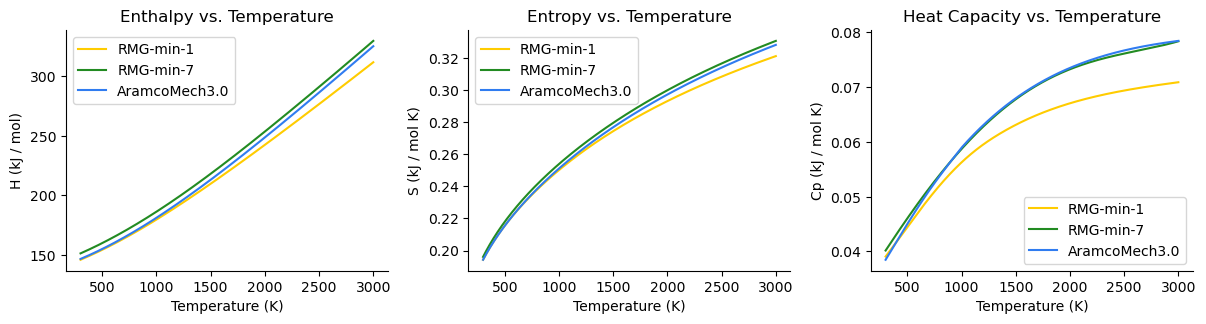

In [15]:
# plot the thermo for species 21

ref_sp = database_fun.index2species(21)
display(ref_sp)
for i in range(len(species_list1)):
    if species_list1[i].is_isomorphic(ref_sp):
        sp21_1 = species_list1[i]
        
for i in range(len(species_list7)):
    if species_list7[i].is_isomorphic(ref_sp):
        sp21_7 = species_list7[i]
        
for i in range(len(species_listA)):
    if species_listA[i].is_isomorphic(ref_sp):
        sp21_A = species_listA[i]

my_labels = ['RMG-min-1', 'RMG-min-7', 'AramcoMech3.0']
plot_thermos([sp21_1, sp21_7, sp21_A], labels=my_labels)

1 288


[OH] + CCCC = O + [CH2]CCC


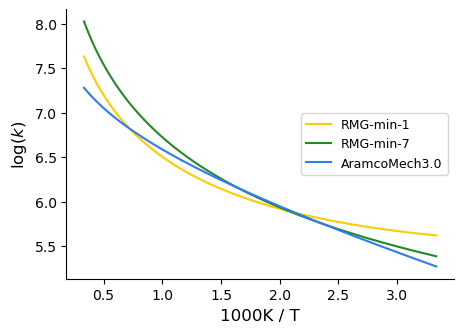

2 4724


OO + C[CH]CC = [O]O + CCCC
Reversing Aramco


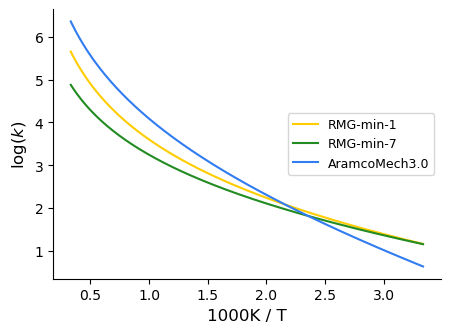

3 5046


COO + C[CH]CC = CO[O] + CCCC
Reversing Aramco


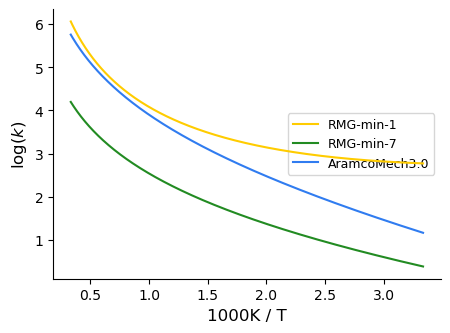

4 4778


C[CH]CC + CCCCOO = CCCCO[O] + CCCC
Reversing Aramco


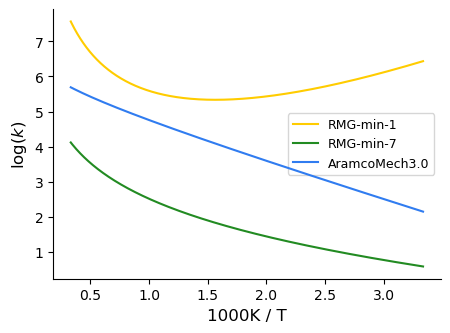

5 4736


OO + [CH2]CCC = [O]O + CCCC
Reversing Aramco


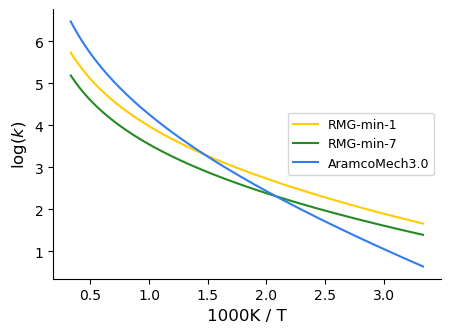

6 4729


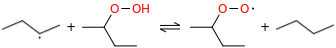

C[CH]CC + CCC(C)OO = CCC(C)O[O] + CCCC
Reversing Aramco


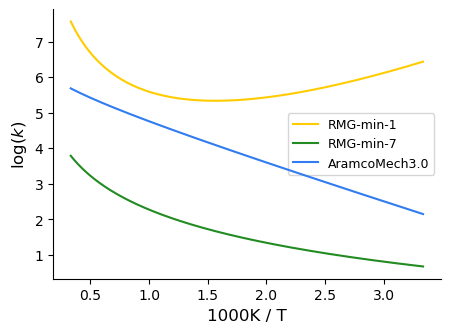

7 4728


CCOO + C[CH]CC = CCO[O] + CCCC
Reversing Aramco


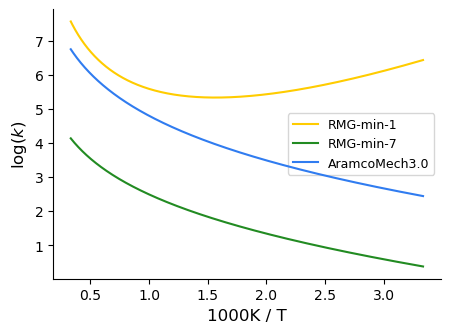

8 50
multiple kinetics for  50


[O][O] + C[C]=O = [O]O + C=C=O


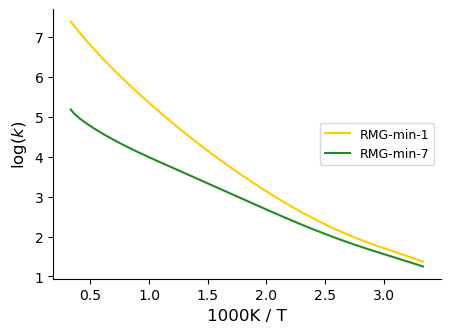

9 4752


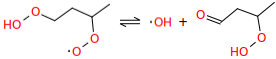

CC(CCOO)O[O] = [OH] + CC(CC=O)OO


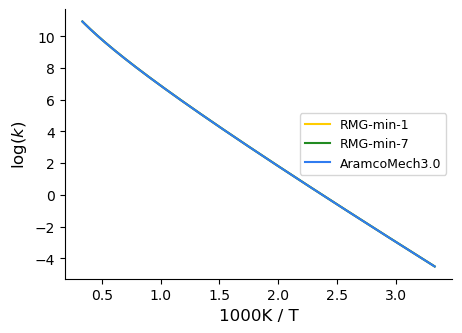

10 5047


COO + [CH2]CCC = CO[O] + CCCC
Reversing Aramco


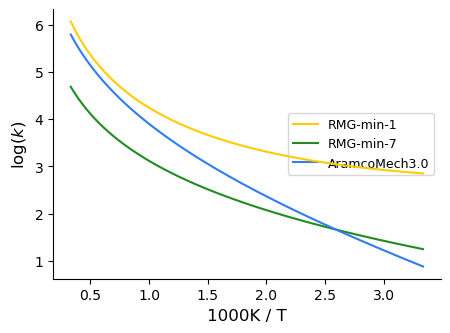

11 4779


[CH2]CCC + CCCCOO = CCCCO[O] + CCCC
Reversing Aramco


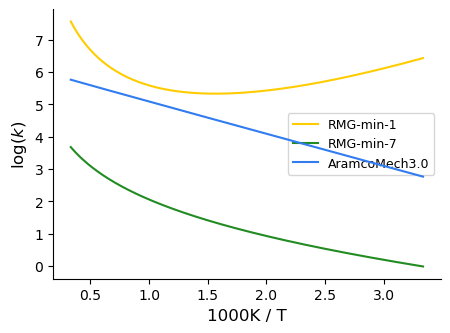

12 286


[CH3] + CCCC = C + [CH2]CCC


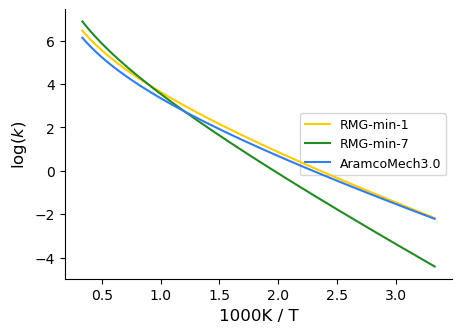

13 246


[H] + CCCC = [H][H] + C[CH]CC


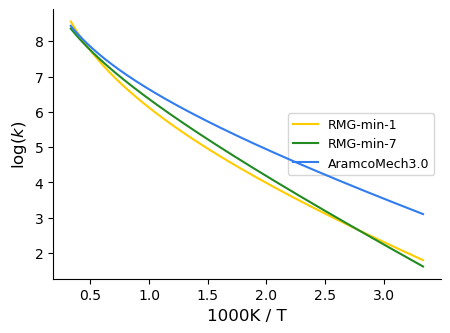

14 5596


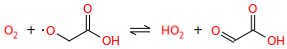

[O][O] + [O]CC(=O)O = [O]O + O=CC(=O)O


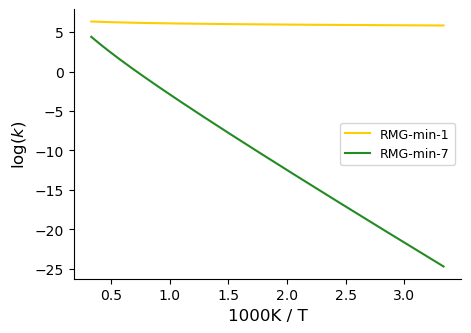

15 808


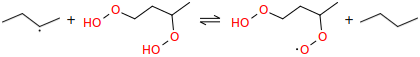

C[CH]CC + CC(CCOO)OO = CC(CCOO)O[O] + CCCC


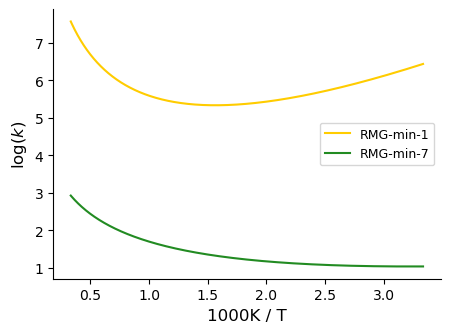

16 915


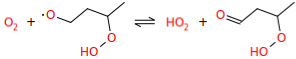

[O][O] + CC(CC[O])OO = [O]O + CC(CC=O)OO


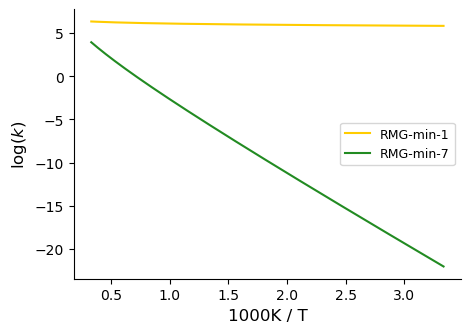

17 4732


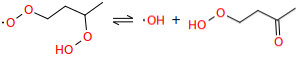

CC(CCO[O])OO = [OH] + CC(=O)CCOO


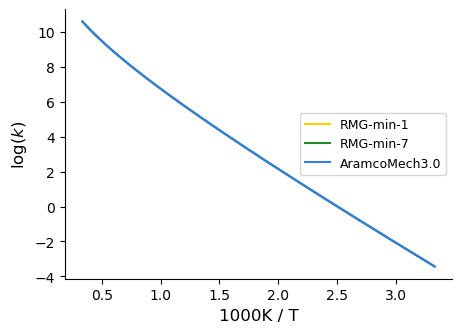

18 518


[O][O] + C[O] = [O]O + C=O


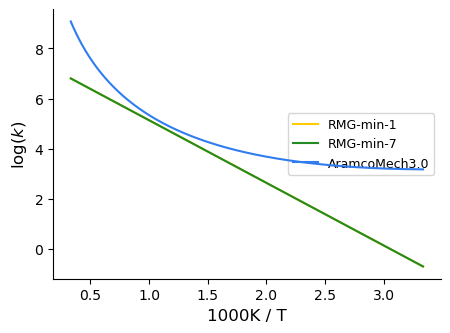

19 4737


CCOO + [CH2]CCC = CCO[O] + CCCC
Reversing Aramco


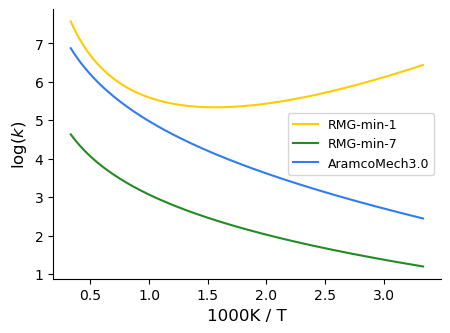

20 5446


[O][O] + [O]CCCCOO = [O]O + O=CCCCOO


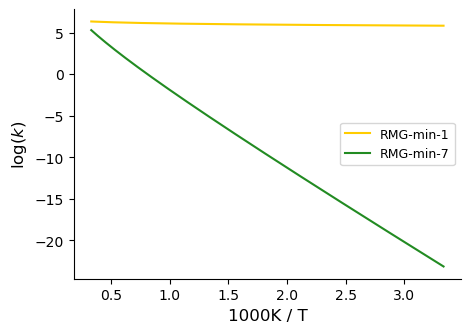

21 324


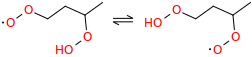

CC(CCO[O])OO = CC(CCOO)O[O]


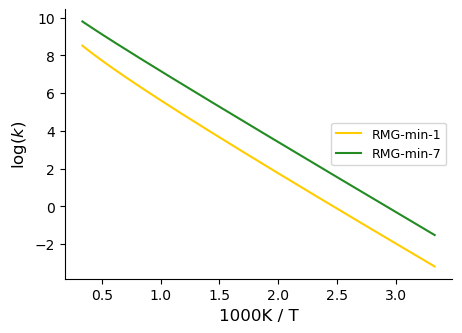

22 4738


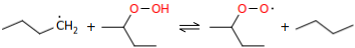

[CH2]CCC + CCC(C)OO = CCC(C)O[O] + CCCC
Reversing Aramco


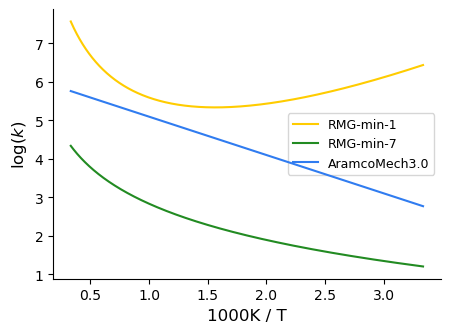

23 7841


[O][O] + [O]CCCC=O = [O]O + O=CCCC=O


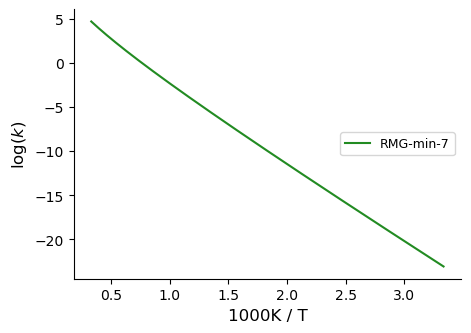

24 804


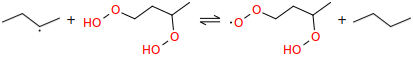

C[CH]CC + CC(CCOO)OO = CC(CCO[O])OO + CCCC


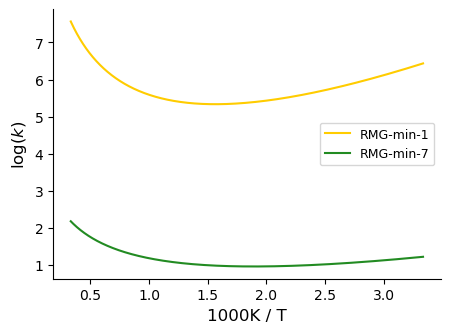

25 809


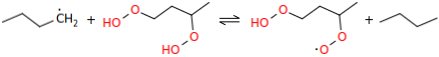

[CH2]CCC + CC(CCOO)OO = CC(CCOO)O[O] + CCCC


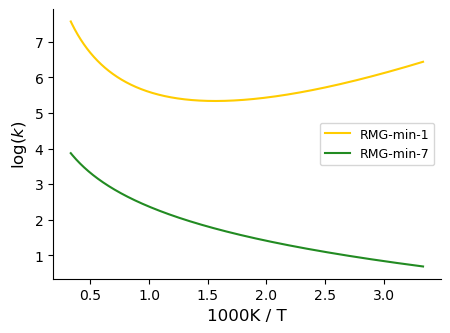

26 4721


[O]O + C[CH]CC = [O][O] + CCCC
Reversing Aramco


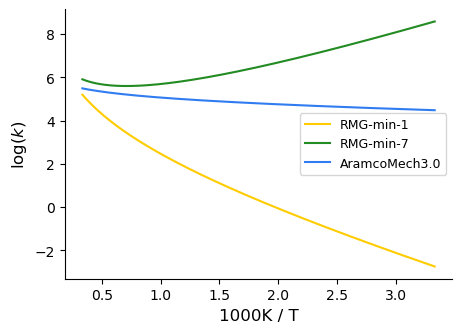

27 245


[CH3] + CCCC = C + C[CH]CC


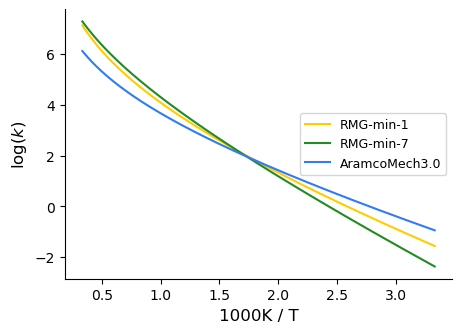

28 945


[O][O] + CC[O] = [O]O + CC=O


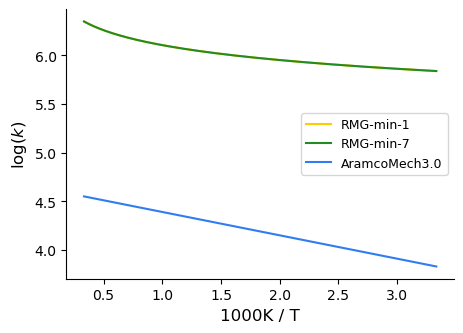

29 213


[O]O + C[CH2] = OO + C=C


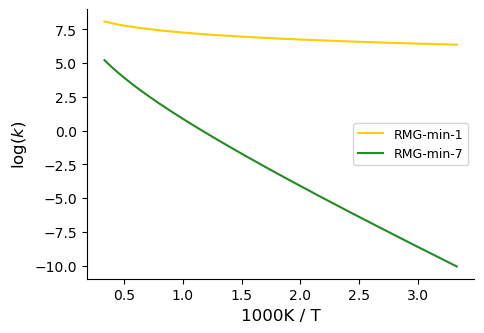

30 289


[O] + CCCC = [OH] + [CH2]CCC


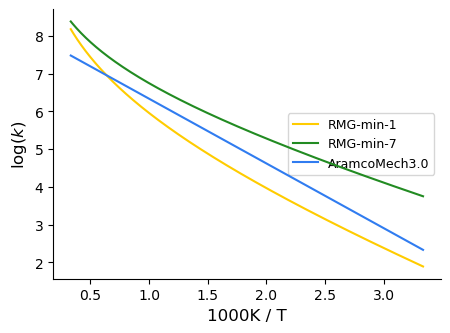

32 422


[O]O + C[CH]CC = OO + C=CCC


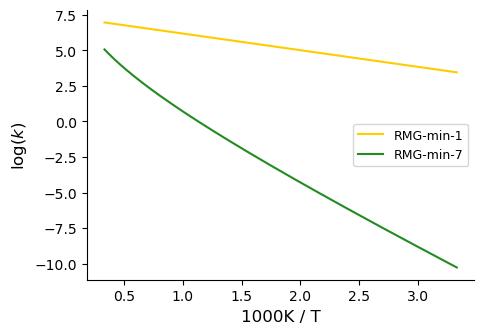

33 805


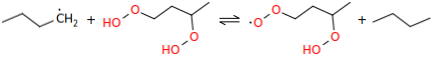

[CH2]CCC + CC(CCOO)OO = CC(CCO[O])OO + CCCC


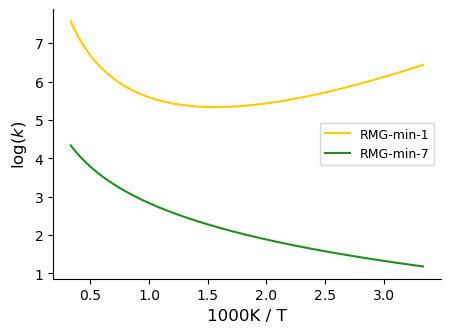

34 4796


[O]O + CCCCO[O] = [O][O] + CCCCOO


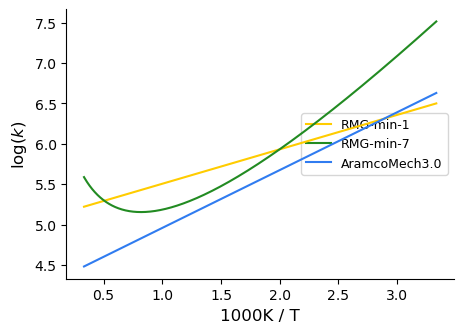

35 1077


[O]O + CO[O] = [O][O] + COO


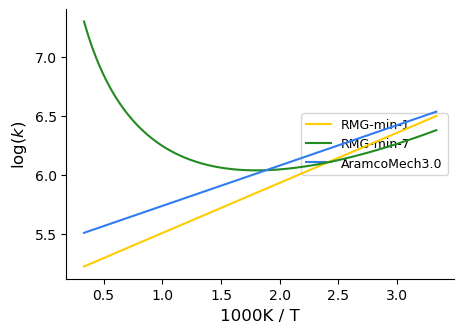

36 1111


CO[O] + C[CH2] = COO + C=C


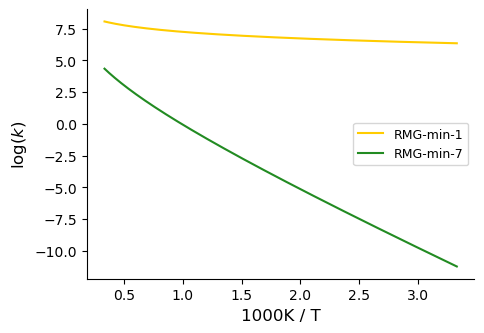

37 1706


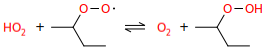

[O]O + CCC(C)O[O] = [O][O] + CCC(C)OO


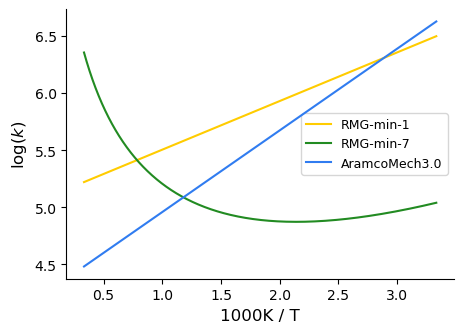

38 4917


C[CH2] + CCCCO[O] = C=C + CCCCOO


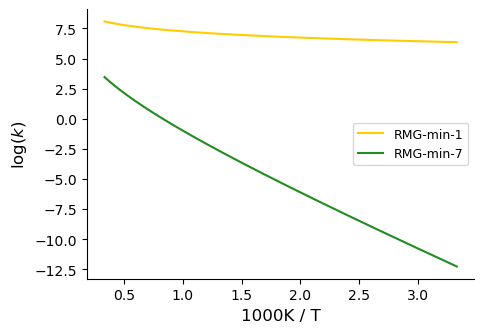

39 417


[OH] + C[CH]CC = O + CC=CC


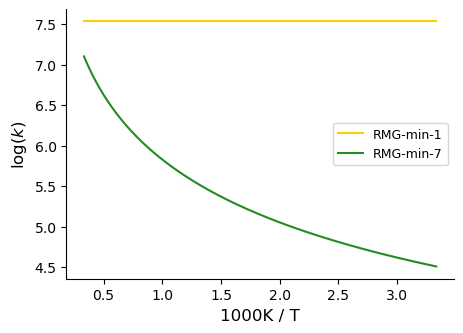

40 319
multiple kinetics for  319


[CH2]CCC + C[CH]CC = C=CCC + CCCC


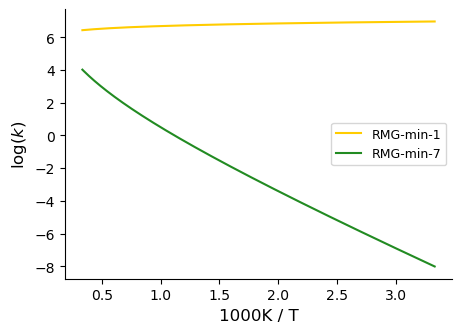

41 313
multiple kinetics for  313


[O][O] + [CH2]CCC = [O]O + C=CCC


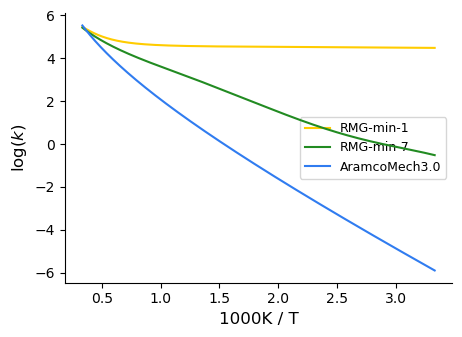

42 278
multiple kinetics for  278


[O][O] + C[CH]CC = [O]O + CC=CC


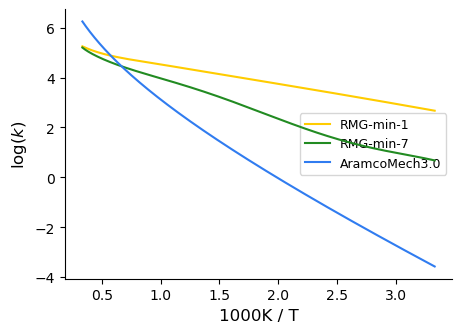

43 314
multiple kinetics for  314


[O][O] + C[CH]CC = [O]O + C=CCC


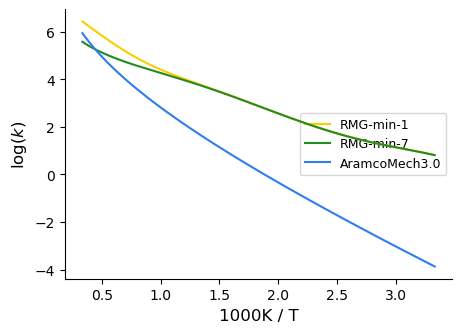

44 52
multiple kinetics for  52


[O][O] + C=C[O] = [O]O + C=C=O
Reversing Aramco


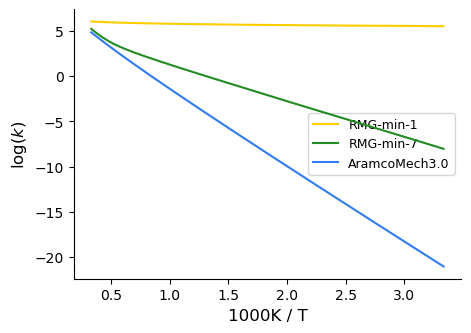

45 5056


COO + C=C[O] = CO[O] + CC=O


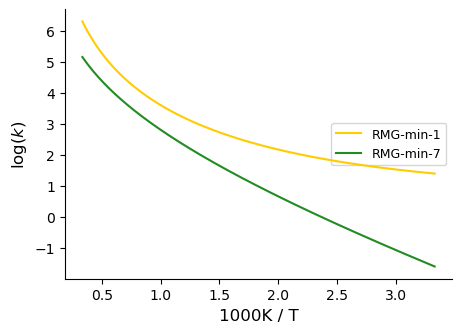

46 405


[OH] + C[CH]CC = O + C=CCC


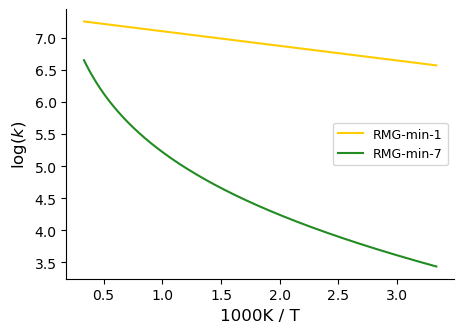

47 5102


C[O] + CCCCO[O] = C=O + CCCCOO


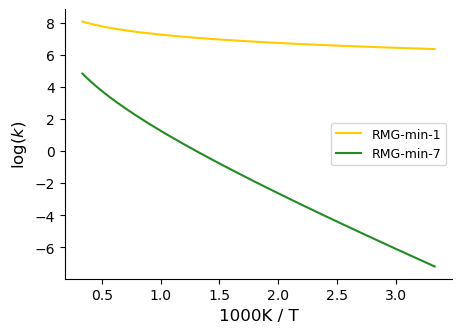

48 521


[O]O + C[O] = OO + C=O


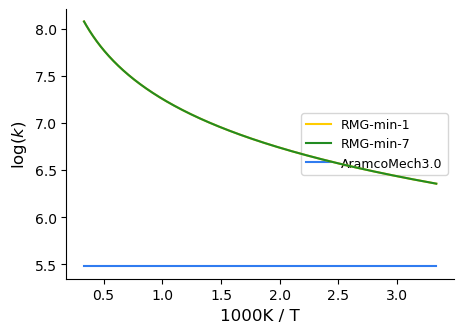

49 404


[OH] + [CH2]CCC = O + C=CCC


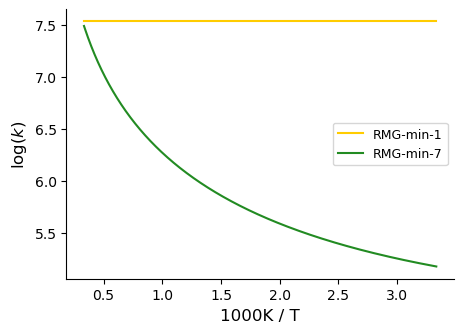

50 410


[CH3] + [CH2]CCC = C + C=CCC


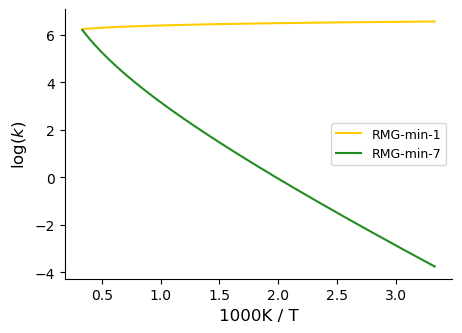

51 4733


[O]O + [CH2]CCC = [O][O] + CCCC
Reversing Aramco


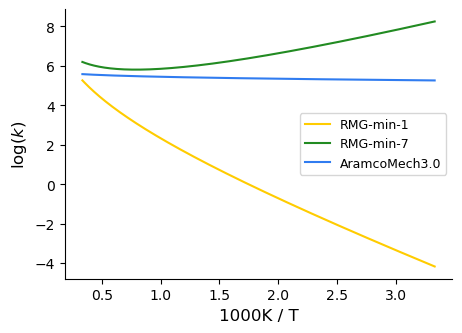

52 296


C=C[O] + [CH2]CCC = C=C=O + CCCC


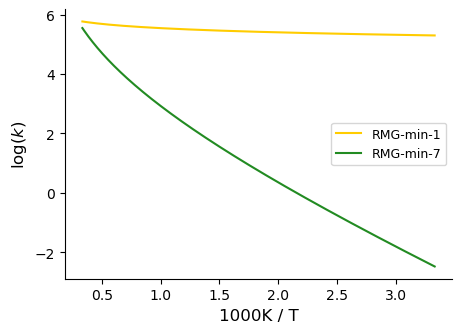

53 321


[CH2]CCC + [CH2]CCC = C=CCC + CCCC


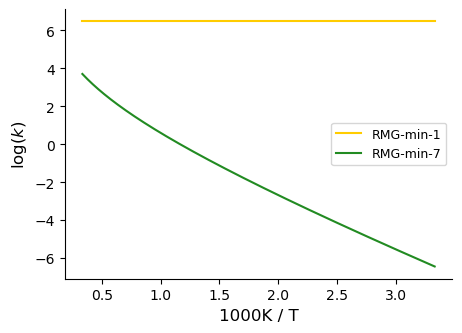

54 301


[CH2]CCC + C[CH]CC = CC=CC + CCCC


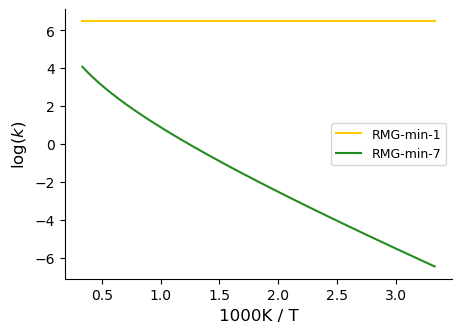

55 280


C[CH]CC + C[CH]CC = CC=CC + CCCC


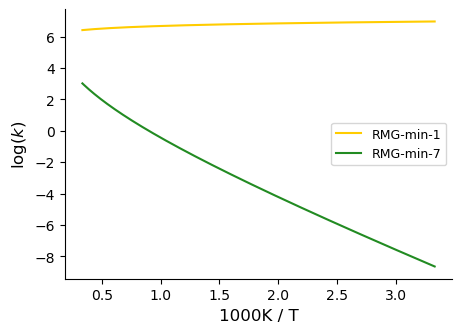

56 253


C=C[O] + C[CH]CC = C=C=O + CCCC


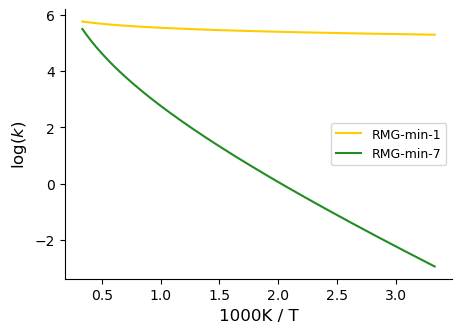

57 459


[CH3] + C[CH]CC = C + CC=CC


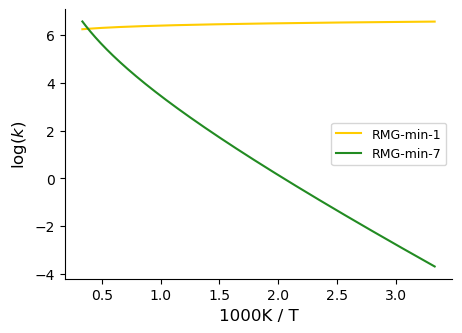

58 1736


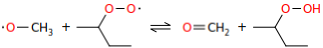

C[O] + CCC(C)O[O] = C=O + CCC(C)OO


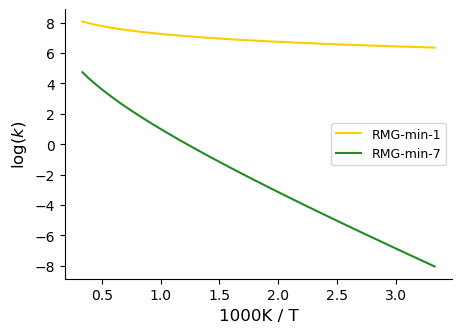

59 1778


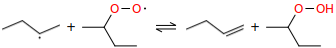

C[CH]CC + CCC(C)O[O] = C=CCC + CCC(C)OO


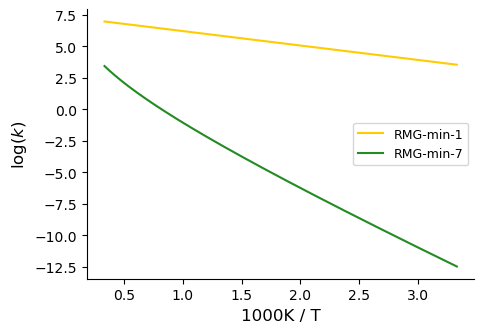

60 299


C[CH2] + [CH2]CCC = C=C + CCCC


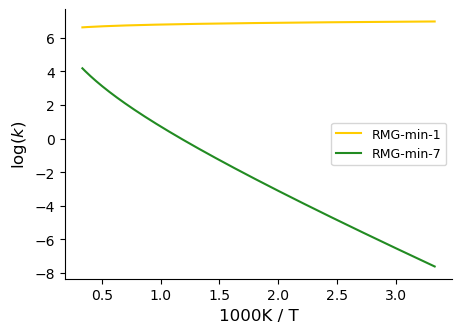

In [16]:


# plot_list= [4779]

errors = np.zeros(len(plot_list))
for m, db_index in enumerate(plot_list):
#     if m < 30:
#         continue
    
    if m >= 30:
        print(m+2, db_index)
    else:
        print(m+1, db_index)
    
    ref_rxn = database_fun.index2reaction(db_index)
    my_kinetics = []
    my_labels = ['RMG-min-1', 'RMG-min-7', 'AramcoMech3.0']
    matches1 = get_reaction_indices(reaction_list1, ref_rxn)
    if matches1:
        my_kinetics.append([reaction_list1[x] for x in matches1])
        for rxn in [reaction_list1[x] for x in matches1]:
            assert reactions_in_same_direction(rxn, reaction_list1[matches1[0]])
    else:
        my_kinetics.append(None)
        
    
#     print(reaction_list1[matches1[0]].kinetics)
    if matches1 and type(reaction_list1[matches1[0]].kinetics) != rmgpy.kinetics.arrhenius.Arrhenius:
        print(reaction_list1[matches1[0]].kinetics)
        raise ValueError('Non-Arrhenius kinetics!')
    if len(matches1) > 1:
        print('multiple kinetics for ', db_index)
        
    matches7 = get_reaction_indices(reaction_list7, ref_rxn)
    if matches7:
        my_kinetics.append([reaction_list7[x] for x in matches7])
        for rxn in [reaction_list7[x] for x in matches7]:
            assert reactions_in_same_direction(rxn, reaction_list7[matches7[0]])
    else:
        my_kinetics.append(None)
    display(reaction_list7[matches7[0]])
#     print(reaction_list7[matches7[0]].kinetics)
    
    print(print_smiles(reaction_list7[matches7[0]]))
    
    matchesA = get_reaction_indices(reaction_listA, ref_rxn)
    if matchesA:
        if len(matchesA) > 1:
            print('Aramco has duplicates!')
            raise ValueError
        
        # check for reverse
        if not reactions_in_same_direction(reaction_listA[matchesA[0]], reaction_list7[matches7[0]]):
            print('Reversing Aramco')
            my_kinetics.append([reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()])
        else:
            my_kinetics.append([reaction_listA[matchesA[0]]])
    else:
        my_kinetics.append(None)
        
        
    # get the reaction image
    
    img = mpimg.imread(img_files[m])
    img_width = img.shape[1]
    
    
    
    imagebox = matplotlib.offsetbox.OffsetImage(img, zoom=0.7)
    
    
    if not my_kinetics[0]:
        my_labels = my_labels[1:]
    
    plot_kinetics(my_kinetics, my_labels, title=f'Reaction {db_index}')
    error2 = get_kinetics_error_range(my_kinetics)
    errors[m] = np.average(np.abs(error2[0]) - np.abs(error2[1]))

    
#     print()
#     print()
#     print()

In [ ]:
ref_rxn = database_fun.index2reaction(319)

ids = get_reaction_indices(reaction_list1, ref_rxn)

print(ids)
T = 300
P = 1013250
for i in ids:
    display(reaction_list1[i])
    print(reaction_list1[i].kinetics)
    print(reaction_list1[i].get_rate_coefficient(T, P))

In [ ]:
ref_rxn = database_fun.index2reaction(319)

ids = get_reaction_indices(reaction_list7, ref_rxn)

print(ids)
T = 300
P = 1013250
for i in ids:
    display(reaction_list7[i])
    print(reaction_list7[i].kinetics)
    print(reaction_list7[i].get_rate_coefficient(T, P))

In [ ]:
reaction_listA[matchesA[0]]

In [ ]:

fig = plt.figure(figsize=(10,6))
ax1 = fig.gca()
plt.show()
ax1.spines[['right', 'top']].set_visible(False)
plt.bar(np.arange(len(errors)), errors)
plt.xlabel('Reaction Rank')
plt.ylabel('Log10 error in kinetics')
# ax1 = plt.gca()
# ax1.axis["right"].set_visible(False)
# ax1.axis["top"].set_visible(False)

# dir(ax1)

In [ ]:
database_fun.index2reaction(7841)

In [ ]:
for i in range(len(plot_list)):
    if errors[i] < 0:
        print(plot_list[i], errors[i])

In [ ]:
plot_list[10]

In [ ]:
errors[10]

# reconfigure as a parity plot at 800K

In [ ]:
plot_list = [
    288, 4724, 5046, 4778, 4736, 4729, 4728, 50, 4752, 5047,
    4779, 286, 246, 5596, 808, 915, 4732, 518, 4737, 5446,
    324, 4738, 7841, 804, 809, 4721, 245, 945, 213, 289,
    422, 805, 4796, 1077, 1111, 1706, 4917, 417, 319, # species 21 here
    313, 278, 314, 52, 5056, 405, 5102, 521, 404, 410,
    4733, 296, 321, 301, 280, 253, 459, 1736, 1778, 299
]

T = 830
P = 1013250
aramco_logks = np.zeros(len(plot_list))
rmg1_logks = np.zeros(len(plot_list))
rmg7_logks = np.zeros(len(plot_list))

for m, db_index in enumerate(plot_list):
#     print(m)
    ref_rxn = database_fun.index2reaction(db_index)
    my_kinetics = []
    my_labels = ['RMG-1', 'RMG-7', 'Aramco 3.0']
    matches1 = get_reaction_indices(reaction_list1, ref_rxn)
    if matches1:
        my_kinetics.append([reaction_list1[x] for x in matches1])
        for rxn in [reaction_list1[x] for x in matches1]:
            assert reactions_in_same_direction(rxn, reaction_list1[matches1[0]])
    else:
        my_kinetics.append(None)
        
    matches7 = get_reaction_indices(reaction_list7, ref_rxn)
    if matches7:
        my_kinetics.append([reaction_list7[x] for x in matches7])
        for rxn in [reaction_list7[x] for x in matches7]:
            assert reactions_in_same_direction(rxn, reaction_list7[matches7[0]])
    else:
        my_kinetics.append(None)
#     display(reaction_list7[matches7[0]])
    
    matchesA = get_reaction_indices(reaction_listA, ref_rxn)
    if matchesA:
        if len(matchesA) > 1:
            print('Aramco has duplicates!')
            raise ValueError
        
        # check for reverse
        if not reactions_in_same_direction(reaction_listA[matchesA[0]], reaction_list7[matches7[0]]):
#             print('Reversing Aramco')
            new_rxn = rmgpy.reaction.Reaction()
            new_rxn.reactants = reaction_listA[matchesA[0]].products
            new_rxn.products = reaction_listA[matchesA[0]].reactants
            new_rxn.kinetics = reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()
            my_kinetics.append([new_rxn])
#             my_kinetics.append([reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()])
        else:
            my_kinetics.append([reaction_listA[matchesA[0]]])
    else:
        my_kinetics.append(None)
    
    
    
    k1 = np.nan
    if my_kinetics[0]:
        k1 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[0]])
    rmg1_logks[m] = np.log10(k1)
    
    k7 = np.nan
    if my_kinetics[1]:
        k7 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[1]])
    rmg7_logks[m] = np.log10(k7)
    
    kA = 10 ** -7.5
    if my_kinetics[2]:
        kA = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[2]])
        aramco_logks[m] = np.log10(kA)
    else:
        aramco_logks[m] = np.log10(kA)
        
# #     error2 = get_kinetics_error(my_kinetics)
#     error2 = get_kinetics_error_range(my_kinetics)
#     errors[m] = np.average(np.abs(error2[0]) - np.abs(error2[1]))
#     print(error2)

start_color = mcolors.hex2color(mcolors.CSS4_COLORS['yellow'])  # make it yellow, but fade it 70% with alpha
rmg1_color = (1.0, 0.9, 0.0)
rmg7_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
aramco_color = (0.18627451, 0.48823529, 0.94117647)

pointsize = 50
plt.scatter(aramco_logks, rmg1_logks, label='RMG-min-1', color=rmg1_color, marker='^', alpha=0.6, sizes=pointsize*np.ones(len(aramco_logks)))
plt.scatter(aramco_logks, rmg7_logks, label='RMG-min-7', color=rmg7_color, marker='x', alpha=0.6, sizes=pointsize*np.ones(len(aramco_logks)))



ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
minlim = min(ax.get_xlim()[0], ax.get_ylim()[0])
maxlim = max(ax.get_xlim()[1], ax.get_ylim()[1])
plt.plot(np.linspace(minlim, maxlim, 101), np.linspace(minlim, maxlim, 101), color='grey', linestyle='dashed')
plt.xlim([minlim, maxlim])
plt.ylim([minlim, maxlim])


plt.legend(loc='lower right', fontsize=12)
plt.xlabel('log(k) (AramcoMech3.0)', fontsize=12)
plt.ylabel('log(k) (RMG-min)', fontsize=12)


ax.set_xticks(ax.get_yticks()[1:-1])
# saved_labels = ax.get_xticks()
# ticklabels = ax.get_xticklabels()
# for i, text in enumerate(ticklabels):
#     ticklabels[i].set_text(str(int(saved_labels[i])))
# ticklabels[1].set_text('-Inf')

# print(ax.get_xticklabels())


d = .015  # how big to make the diagonal lines in axes coordinates
offset1 = 0.115
offset2 = 0.14
center = 0.5 * (offset1 + offset2)
# arguments to pass to plot, just so we don't keep repeating them
kwargs1 = dict(transform=ax.transAxes, color='k', clip_on=False, zorder=10)
kwargs2 = dict(transform=ax.transAxes, color='white', clip_on=False, linewidth=8, zorder=7)

# ax.plot((-d +offset1, +d+offset1), (-d, +d), **kwargs1)        # top-left diagonal
# ax.plot((-d +offset2, +d+offset2), (-d, +d), **kwargs1)        # top-left diagonal
# ax.plot((center, center), (-0.05, 1.0), **kwargs2)        # top-left diagonal




# ax.plot((-d +offset1, -d+offset1), (1.0, 1.0), **kwargs1)        # top-left diagonal
# ax.plot((offset1, offset2), (0, 0), **kwargs2)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# With Arrows

In [ ]:
# plt.figure(figsize=(10, 4))
plot_list = [
    288, 4724, 5046, 4778, 4736, 4729, 4728, 50, 4752, 5047,
    4779, 286, 246, 5596, 808, 915, 4732, 518, 4737, 5446,
    324, 4738, 7841, 804, 809, 4721, 245, 945, 213, 289,
    422, 805, 4796, 1077, 1111, 1706, 4917, 417, 319, # species 21 here
    313, 278, 314, 52, 5056, 405, 5102, 521, 404, 410,
    4733, 296, 321, 301, 280, 253, 459, 1736, 1778, 299
]

T = 830
P = 1013250
aramco_logks = np.zeros(len(plot_list))
rmg1_logks = np.zeros(len(plot_list))
rmg7_logks = np.zeros(len(plot_list))

np.random.seed(400)

space_count = 0
for m, db_index in enumerate(plot_list):
#     print(m)
    ref_rxn = database_fun.index2reaction(db_index)
    my_kinetics = []
    my_labels = ['RMG-1', 'RMG-7', 'Aramco 3.0']
    matches1 = get_reaction_indices(reaction_list1, ref_rxn)
    if matches1:
        my_kinetics.append([reaction_list1[x] for x in matches1])
        for rxn in [reaction_list1[x] for x in matches1]:
            assert reactions_in_same_direction(rxn, reaction_list1[matches1[0]])
    else:
        my_kinetics.append(None)
        
    matches7 = get_reaction_indices(reaction_list7, ref_rxn)
    if matches7:
        my_kinetics.append([reaction_list7[x] for x in matches7])
        for rxn in [reaction_list7[x] for x in matches7]:
            assert reactions_in_same_direction(rxn, reaction_list7[matches7[0]])
    else:
        my_kinetics.append(None)
#     display(reaction_list7[matches7[0]])
    
    matchesA = get_reaction_indices(reaction_listA, ref_rxn)
    if matchesA:
        if len(matchesA) > 1:
            print('Aramco has duplicates!')
            raise ValueError
        
        # check for reverse
        if not reactions_in_same_direction(reaction_listA[matchesA[0]], reaction_list7[matches7[0]]):
#             print('Reversing Aramco')
            new_rxn = rmgpy.reaction.Reaction()
            new_rxn.reactants = reaction_listA[matchesA[0]].products
            new_rxn.products = reaction_listA[matchesA[0]].reactants
            new_rxn.kinetics = reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()
            my_kinetics.append([new_rxn])
#             my_kinetics.append([reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()])
        else:
            my_kinetics.append([reaction_listA[matchesA[0]]])
    else:
        my_kinetics.append(None)
    
    
    
    k1 = np.nan
    if my_kinetics[0]:
        k1 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[0]])
    rmg1_logks[m] = np.log10(k1)
    
    k7 = np.nan
    if my_kinetics[1]:
        k7 = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[1]])
    rmg7_logks[m] = np.log10(k7)
    
    kA = 10 ** -12.0
    if my_kinetics[2]:
        kA = np.sum([rxn.get_rate_coefficient(T, P) for rxn in my_kinetics[2]])
        aramco_logks[m] = np.log10(kA)
    else:
        aramco_logks[m] = np.log10(kA) + 0.2 * space_count
        space_count += 1.0
        

start_color = mcolors.hex2color(mcolors.CSS4_COLORS['yellow'])  # make it yellow, but fade it 70% with alpha
rmg1_color = (1.0, 0.9, 0.0)
rmg7_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
aramco_color = (0.18627451, 0.48823529, 0.94117647)

pointsize = 10
# plt.scatter(aramco_logks, rmg1_logks, label='RMG-min-1', color=rmg1_color, marker='^', alpha=0.6, sizes=pointsize*np.ones(len(aramco_logks)))
# plt.scatter(aramco_logks, rmg7_logks, label='RMG-min-7', color=rmg7_color, marker='x', alpha=0.6, sizes=pointsize*np.ones(len(aramco_logks)))

ARROW_OFFSET = -0.025
for i in range(len(rmg7_logks)):
    if rmg7_logks[i] < rmg1_logks[i]:
        label = '_no_legend'
#         if i==0:
#             label = 'RMG-min-1'
        plt.plot(aramco_logks[i, ] + ARROW_OFFSET, rmg1_logks[i, ], marker='v', markersize=6, color=rmg1_color,
                 markeredgewidth=0.4, markeredgecolor='black', label=label)
    else:
        label = '_no_legend'
#         if i==0:
#             label = 'RMG-min-1'
        plt.plot(aramco_logks[i] + ARROW_OFFSET, rmg1_logks[i], marker='^', markersize=6, color=rmg1_color,
                 markeredgewidth=0.4, markeredgecolor='black', label=label)
        
    label7 = '_no_legend'
#     if i == 0:
#         label7='RMG-min-7'
        
#     plt.arrow(aramco_logks[i], rmg1_logks[i], 0, rmg7_logks[i] - rmg1_logks[i], head_width=0.3, linewidth = 0.25, alpha=1.0,
#               facecolor=rmg7_color, label=label7)
    plt.arrow(aramco_logks[i], rmg1_logks[i], 0, rmg7_logks[i] - rmg1_logks[i], head_width=0.35, linewidth = 0.25,
              facecolor=rmg7_color, label=label7, head_length=0.45)


ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
minlim = min(ax.get_xlim()[0], ax.get_ylim()[0])
maxlim = max(ax.get_xlim()[1], ax.get_ylim()[1])
plt.plot(np.linspace(minlim, maxlim, 101), np.linspace(minlim, maxlim, 101), color='grey', linestyle='dashed')
# plt.xlim([minlim - (maxlim - minlim), maxlim])
# plt.xlim([minlim, maxlim])
# plt.ylim([minlim, maxlim])

plt.xlim(-12.6, 6.5)
plt.ylim(-6, 10)


plt.xlabel('log(k) (AramcoMech3.0)', fontsize=12)
plt.ylabel('log(k) (RMG-min)', fontsize=12)


ax.set_xticks(ax.get_yticks()[1:-1])


# Custom legend
yellow_circle = mlines.Line2D([], [], color='yellow', marker='^', linestyle='None',
                          markersize=8, label='RMG-min-1', markeredgewidth=0.5, markeredgecolor='black')
green_triangle = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=8, label='RMG-min-7', markeredgewidth=0.5, markeredgecolor='black')

plt.legend(handles=[yellow_circle, green_triangle], loc='lower right', fontsize=12)


In [ ]:
max(aramco_logks)

# Plot RMG-MAX things

In [17]:
# plot RMG-MAX things
plot_list = [
    213, 324, 915, 808, 422, 97, 809, 459, 804, 101
]

In [18]:
# load Aramco, RMG, and uncertainties
mech_1_inp = '/home/moon/autoscience/aramco/flux_diagram/chem_annotated.inp'
mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
mech_1_label = 'AramcoMech3.0'
species_listA, reaction_listA = rmgpy.chemkin.load_chemkin_file(mech_1_inp, mech_1_dict)

mech_2_inp = '/home/moon/autoscience/fuels/with_lib/butane_20240401/chem_annotated.inp'
mech_2_dict = '/home/moon/autoscience/fuels/with_lib/butane_20240401/species_dictionary.txt'
mech_2_label = 'RMG-MAX-1'
species_list1, reaction_list1 = rmgpy.chemkin.load_chemkin_file(mech_2_inp, mech_2_dict)

mech_3_inp = '/home/moon/autoscience/fuels/with_lib/butane_20240413/chem_annotated.inp'
mech_3_dict = '/home/moon/autoscience/fuels/with_lib/butane_20240413/species_dictionary.txt'
mech_3_label = 'RMG-MAX-2'
species_list7, reaction_list7 = rmgpy.chemkin.load_chemkin_file(mech_3_inp, mech_3_dict)


1 213


[O]O + C[CH2] = OO + C=C


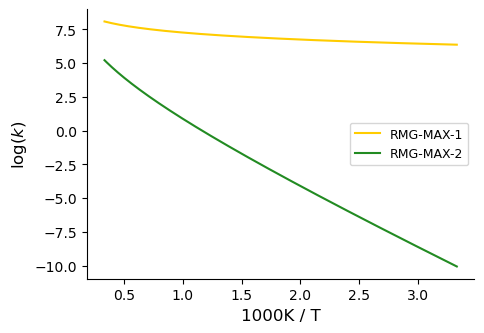

2 324


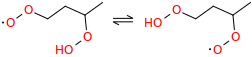

CC(CCO[O])OO = CC(CCOO)O[O]


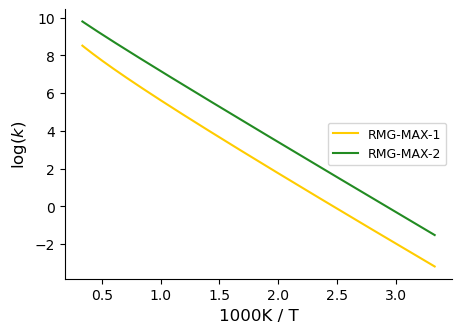

3 915


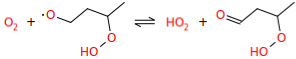

[O][O] + CC(CC[O])OO = [O]O + CC(CC=O)OO


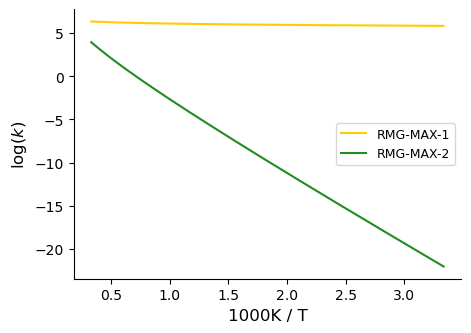

4 808


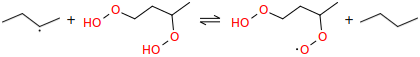

C[CH]CC + CC(CCOO)OO = CC(CCOO)O[O] + CCCC


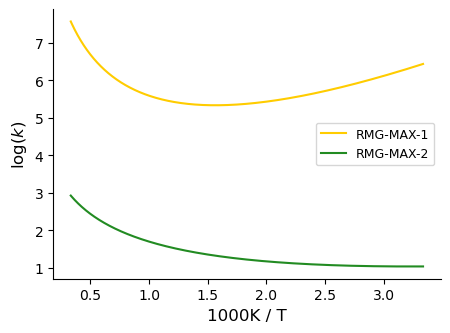

5 422


[O]O + C[CH]CC = OO + C=CCC


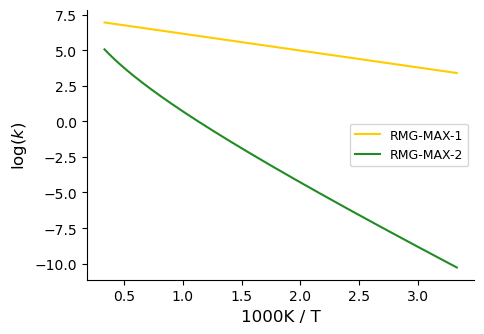

6 97


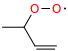

C=CC(C)O[O]
7 809


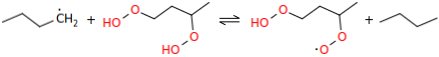

[CH2]CCC + CC(CCOO)OO = CC(CCOO)O[O] + CCCC


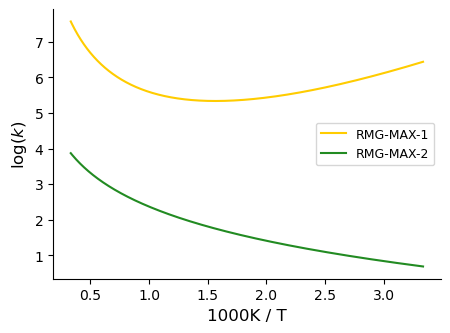

8 459


[CH3] + C[CH]CC = C + CC=CC


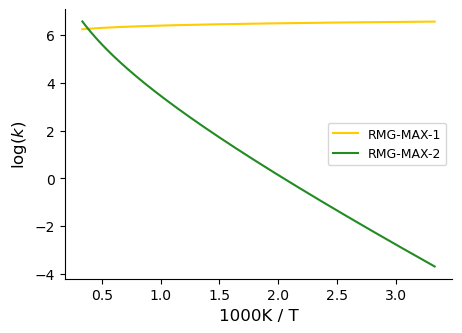

9 804


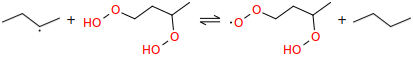

C[CH]CC + CC(CCOO)OO = CC(CCO[O])OO + CCCC


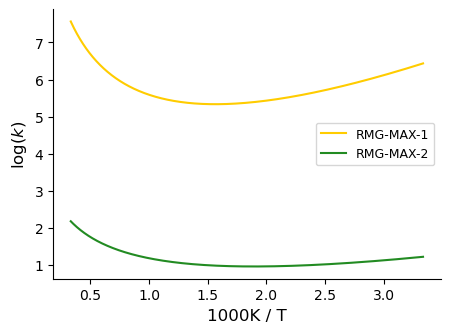

10 101


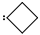

[C]1CCC1


In [19]:
errors = np.zeros(len(plot_list))
for m, db_index in enumerate(plot_list):
    print(m + 1, db_index)
    ref_rxn = database_fun.index2reaction(db_index)
    if db_index in [97, 101]:
        ref_sp = database_fun.index2species(db_index)
        display(ref_sp)
        print(ref_sp.smiles)
        continue
    my_kinetics = []
    my_labels = ['RMG-MAX-1', 'RMG-MAX-2', 'AramcoMech3.0']
    matches1 = get_reaction_indices(reaction_list1, ref_rxn)
    if matches1:
        my_kinetics.append([reaction_list1[x] for x in matches1])
        for rxn in [reaction_list1[x] for x in matches1]:
            assert reactions_in_same_direction(rxn, reaction_list1[matches1[0]])
    else:
        my_kinetics.append(None)
        
    
#     print(reaction_list1[matches1[0]].kinetics)
    if matches1 and type(reaction_list1[matches1[0]].kinetics) != rmgpy.kinetics.arrhenius.Arrhenius:
        print(reaction_list1[matches1[0]].kinetics)
        raise ValueError('Non-Arrhenius kinetics!')
    if len(matches1) > 1:
        print('multiple kinetics for ', db_index)
        
    matches7 = get_reaction_indices(reaction_list7, ref_rxn)
    if matches7:
        my_kinetics.append([reaction_list7[x] for x in matches7])
        for rxn in [reaction_list7[x] for x in matches7]:
            assert reactions_in_same_direction(rxn, reaction_list7[matches7[0]])
    else:
        my_kinetics.append(None)
    display(reaction_list7[matches7[0]])
#     print(reaction_list7[matches7[0]].kinetics)
    
    print(print_smiles(reaction_list7[matches7[0]]))
    
    matchesA = get_reaction_indices(reaction_listA, ref_rxn)
    if matchesA:
        if len(matchesA) > 1:
            print('Aramco has duplicates!')
            raise ValueError
        
        # check for reverse
        if not reactions_in_same_direction(reaction_listA[matchesA[0]], reaction_list7[matches7[0]]):
            print('Reversing Aramco')
            my_kinetics.append([reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()])
        else:
            my_kinetics.append([reaction_listA[matchesA[0]]])
    else:
        my_kinetics.append(None)
        
        
    # get the reaction image
    
    img = mpimg.imread(img_files[m])
    img_width = img.shape[1]
    
    
    
    imagebox = matplotlib.offsetbox.OffsetImage(img, zoom=0.7)
    
    
    if not my_kinetics[0]:
        my_labels = my_labels[1:]
    
    plot_kinetics(my_kinetics, my_labels, title=f'Reaction {db_index}')
    error2 = get_kinetics_error_range(my_kinetics)
    errors[m] = np.average(np.abs(error2[0]) - np.abs(error2[1]))

    
#     print()
#     print()
#     print()

In [ ]:
# plot the thermo for species 97, 101

ref_sp = database_fun.index2species(101)
display(ref_sp)
for i in range(len(species_list1)):
    if species_list1[i].is_isomorphic(ref_sp):
        sp21_1 = species_list1[i]
        
for i in range(len(species_list7)):
    if species_list7[i].is_isomorphic(ref_sp):
        sp21_7 = species_list7[i]
        
for i in range(len(species_listA)):
    if species_listA[i].is_isomorphic(ref_sp):
        sp21_A = species_listA[i]

my_labels = ['RMG-MAX-1', 'RMG-MAX-2', 'AramcoMech3.0']
plot_thermos([sp21_1, sp21_7, sp21_A], labels=my_labels)